In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

In [2]:

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001


In [3]:

# CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


Files already downloaded and verified


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid())
        

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = self.upsample(encoded)
        decoded = self.decoder(encoded)
        return encoded, decoded




In [5]:

model = Autoencoder()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:

main_bar = tqdm(total=num_epochs,desc='Main Process')
sub_bar = tqdm(total=len(train_loader),desc='Sub Process')
num_epochs=10
# Train the model
for epoch in range(num_epochs):
    main_bar.update(1)
    sub_bar.reset()
    for data in train_loader:
        sub_bar.update(1)
        img, _ = data
        _, recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, loss.item()))

Main Process:   0%|          | 0/10 [00:00<?, ?it/s]

Sub Process:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0177
Epoch [2/10], Loss: 0.0135
Epoch [3/10], Loss: 0.0114
Epoch [4/10], Loss: 0.0102
Epoch [5/10], Loss: 0.0084
Epoch [6/10], Loss: 0.0079
Epoch [7/10], Loss: 0.0079
Epoch [8/10], Loss: 0.0084
Epoch [9/10], Loss: 0.0082
Epoch [10/10], Loss: 0.0074


In [9]:
# Test the model
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        encoded, recon = model(img)
        print(recon.shape)
        break


torch.Size([128, 3, 32, 32])


torch.Size([3, 32, 32])


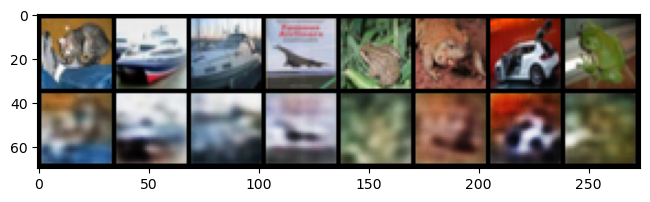

In [8]:

# Visualize the reconstructed images
import matplotlib.pyplot as plt
print(img[0].shape)
n = min(img.size(0), 8)
comparison = torch.cat([img[:n], recon[:n]])
comparison = comparison.cpu()
plt.figure(figsize=(n*2, 2))
plt.imshow(torchvision.utils.make_grid(comparison, nrow=n).permute(1, 2, 0))
plt.show()